In [39]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [41]:
dataset = load_dataset(path=r"C:\Users\mlfav\lib\shlee\color_model\ColorPalette4", split="train")
dataset.set_format(type="torch", columns=["input_colors", "output_color"], dtype=torch.float32)
dataset.shape

(57243, 3)

In [42]:
from torch.utils.data import random_split
total_size = len(dataset)
train_size = int(total_size * 0.6)
valid_size = total_size - train_size
train_data, valid_data = random_split(dataset, [train_size, valid_size])

In [43]:
train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=4, shuffle=True, num_workers=2, drop_last=True)

In [44]:
train_size, valid_size

(34345, 22898)

In [45]:
import torch.nn as nn

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(in_features=4*3, out_features=24)
        self.layer2 = nn.Linear(in_features=24, out_features=48)
        self.normalize = nn.LayerNorm((48,))
        self.layer3 = nn.ReLU()
        self.layer4 = nn.Linear(in_features=48, out_features=24)
        self.normalize2 = nn.LayerNorm((24,))
        self.layer5 = nn.ReLU()
        self.layer6 = nn.Linear(in_features=24, out_features=12)
        self.layer7 = nn.Linear(in_features=12, out_features=3)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.normalize(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.normalize2(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)

        return x

In [46]:
model = Model().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0002, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.0002,
                                              step_size_up=5, max_lr=0.0005,
                                              gamma=0.5, mode='exp_range')
learning_rate = []

In [47]:
def train(train_loader):
    train_loss = []
    for data in train_loader:
        x = data['input_colors'].to(device)
        y = data['output_color'].to(device)

        optimizer.zero_grad()
        output = model.forward(x)

        loss = loss_func(output, y)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.cpu().detach().numpy())
    scheduler.step()
    learning_rate.append(scheduler.get_last_lr()[0])
    return np.array(train_loss).mean()

def valid(valid_loader):
    valid_loss = []
    for data in valid_loader:
        x = data['input_colors'].to(device)
        y = data['output_color'].to(device)

        output = model.forward(x)
        loss = loss_func(output, y)
        valid_loss.append(loss.cpu().detach().numpy())
    return np.array(valid_loss).mean()

In [48]:
train_loss = []
valid_loss = []

for epoch in range(8):
    
    t_loss = train(train_loader)
    v_loss = valid(valid_loader)
    train_loss.append(t_loss)
    valid_loss.append(v_loss)
    print(f"train: {t_loss}, valid: {v_loss}")

train: 3796.477294921875, valid: 3633.25048828125
train: 3751.362548828125, valid: 3711.49609375
train: 3727.428466796875, valid: 3574.306884765625
train: 3709.028564453125, valid: 3795.07763671875
train: 3710.408447265625, valid: 3651.443359375
train: 3675.386474609375, valid: 3568.97509765625
train: 3657.701171875, valid: 3590.751220703125
train: 3635.46044921875, valid: 3561.662353515625


0.00023000
0.00023000
0.00022250
0.00021500
0.00020938
0.00020375
0.00020141
0.00020047


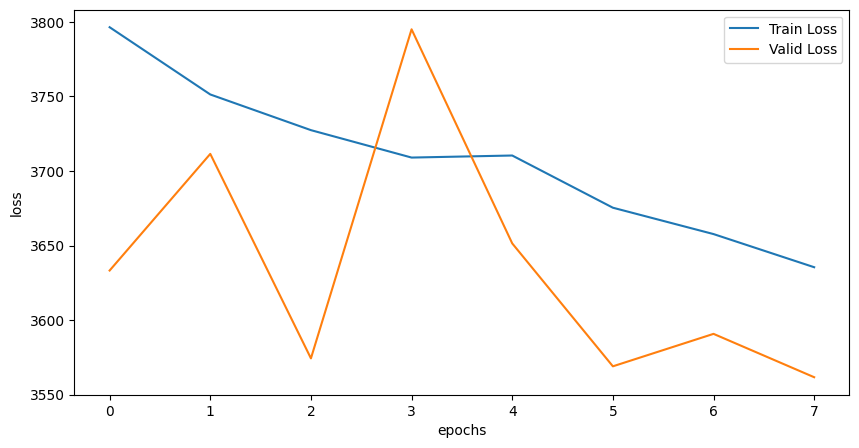

In [49]:
for lr in learning_rate:
    print(format(lr, '.8f'))

plt.figure(figsize=(10,5))
plt.plot([float(loss) for loss in train_loss], label='Train Loss')
plt.plot([float(loss) for loss in valid_loss], label='Valid Loss')
# plt.plot([float(lr[0]) for lr in learning_rate], label='Learning Rate')

plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [50]:
with torch.no_grad():
    data = train_loader.__iter__().__next__()
    x = data['input_colors'].to(device)
    y = data['output_color']
    output = model.forward(x).type(torch.int)

In [51]:
print(x)
print(y)
print(output)

tensor([[182., 182., 182.,   5.,   5.,   5., 132., 132., 132., 124., 124., 124.],
        [204., 191., 204., 183., 154., 175., 191., 169., 189., 178., 146., 163.],
        [116., 214., 107.,  46., 176., 108., 238., 191., 110., 185., 177., 203.],
        [204.,  48.,  91.,  33.,  44.,  79., 218., 202.,  85., 194., 157.,  73.]],
       device='cuda:0')
tensor([[ 88.,  88.,  88.],
        [185., 164., 179.],
        [198.,  66., 126.],
        [113.,  26.,  51.]])
tensor([[126, 119, 107],
        [126, 119, 107],
        [126, 119, 107],
        [126, 119, 107]], device='cuda:0', dtype=torch.int32)


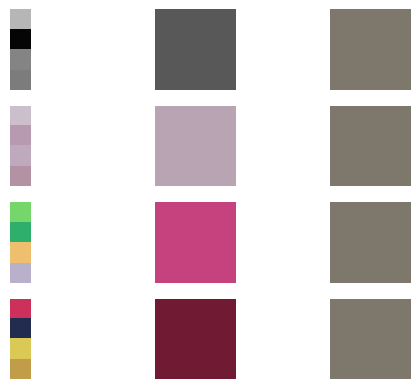

In [52]:
for i in range(4):
    x_tmp = x[i].type(torch.int).cpu().detach().numpy().reshape((4,1,3))
    y_tmp = y[i].type(torch.int).numpy().reshape((1,3))
    output_tmp = output[i].cpu().detach().numpy().reshape((1,3))
    plt.subplot(4, 3, i*3+1)
    plt.imshow([x_tmp[i] for i in range(4)])
    plt.axis(False)
    plt.subplot(4, 3, i*3+2)
    plt.imshow([y_tmp])
    plt.axis(False)
    plt.subplot(4, 3, i*3+3)
    plt.imshow([output_tmp])
    plt.axis(False)
